# Walmart 구매 데이터 분석 보고서 

## 한 줄 요약
월마트 구매 데이터에서 도시 유형, 거주 기간, 제품 카테고리에 따라 구매금액 분포가 달라지는지를 가설 검정과 시각화로 확인했다.

## 분석 목표
1) 마스킹된 범주형 변수(도시/직업/카테고리)를 과해석하지 않고, 유형 간 차이 존재 여부를 확인한다.  
2) 차이가 있더라도 그 크기가 실무적으로 의미 있는 수준인지 효과크기까지 함께 본다.  
3) 그래프는 장식이 아니라 근거로 사용하고, 각 결과는 문장으로 정리한다.

## 데이터 해석 주의
City_Category, Occupation, Product_Category는 마스킹된 값이다.  
따라서 A가 대도시 같은 의미를 부여하지 않고, 유형(A/B/C) 간 차이로만 해석한다.

## 데이터 설명
- 데이터 출처: Kaggle의 Wallmart 데이터 셋
- 데이터 상세: 약 55만개의 사용자 거래 내역과 10개의 특징(550068, 10)
- User_ID: User ID
- Product_ID: Product ID
- Gender: Sex of User
- Age: Age in bins
- Occupation: Occupation(Masked)
- City_Category: Category of the City (A,B,C)
- StayInCurrentCityYears: Number of years stay in current city
- Marital_Status: Marital Status
- ProductCategory: Product Category (Masked)
- Purchase: Purchase Amount

## 0. 환경 설정

그래프에서 한글이 깨지지 않도록 폰트를 먼저 설정한다.  
Windows 환경에서는 맑은 고딕을 폰트 파일 경로로 강제 등록하는 방식이 가장 안정적이다.

In [14]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 1) seaborn 먼저 세팅 (여기서 폰트가 종종 덮어써짐)
sns.set_theme(style="whitegrid")

# 2) 그 다음 폰트를 "강제"로 박기
font_path = r"C:\Windows\Fonts\malgun.ttf"
if not os.path.exists(font_path):
    raise FileNotFoundError(f"폰트 파일 없음: {font_path}")

font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# 3) seaborn에도 폰트 명시 (덮어쓰기 방지)
sns.set_theme(style="whitegrid", font=font_name)

print("설정된 폰트:", font_name)
print("rcParams font.family:", rcParams["font.family"])


설정된 폰트: Malgun Gothic
rcParams font.family: ['Malgun Gothic']


## 1. 데이터 불러오기

파일 경로만 본인 환경에 맞게 수정한다.

In [15]:
# df = pd.read_csv("./data/walmart.csv")
df = pd.read_csv("./data/walmart.csv")
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


## 2. 데이터 구조 및 품질 점검

이 단계에서는 결측치, 타입, Purchase 스케일을 확인한다.  
결측치가 없다면, 전처리는 변수 타입 정리에 집중하면 된다.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [17]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

In [18]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User_ID,550068.0,NaN,NaN,NaN,1003028.842401,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Product_ID,550068,3631,P00265242,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,550068.0,NaN,NaN,NaN,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,550068.0,NaN,NaN,NaN,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Product_Category,550068.0,NaN,NaN,NaN,5.40427,3.936211,1.0,1.0,5.0,8.0,20.0
Purchase,550068.0,NaN,NaN,NaN,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


## 3. 전처리

분석에서 필요한 전처리만 수행한다.

- 숫자인 척하는 범주형: Occupation, Product_Category, Marital_Status → category
- 순서형 범주: Age, Stay_In_Current_City_Years → ordered category

이 설정은 시각화 축 정렬과 이후 교차분석 해석을 안정화하는 목적이다.

In [19]:
df.columns = df.columns.str.strip()

for col in ["Occupation", "Product_Category", "Marital_Status"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

age_order = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
if "Age" in df.columns:
    df["Age"] = pd.Categorical(df["Age"], categories=age_order, ordered=True)

stay_order = ['0', '1', '2', '3', '4+']
if "Stay_In_Current_City_Years" in df.columns:
    df["Stay_In_Current_City_Years"] = pd.Categorical(
        df["Stay_In_Current_City_Years"], categories=stay_order, ordered=True
    )

df.dtypes

User_ID                          int64
Product_ID                      object
Gender                          object
Age                           category
Occupation                    category
City_Category                   object
Stay_In_Current_City_Years    category
Marital_Status                category
Product_Category              category
Purchase                         int64
dtype: object

## 4. 데이터 개요(요약 지표)

보고서 첫 부분에 들어갈 수 있는 지표를 정리한다.

In [20]:
summary = pd.DataFrame({
    "총 거래 수": [len(df)],
    "총 고객 수": [df["User_ID"].nunique()],
    "총 상품 수": [df["Product_ID"].nunique()],
    "총 매출(합계 Purchase)": [df["Purchase"].sum()],
    "평균 구매금액": [df["Purchase"].mean()],
    "중앙값 구매금액": [df["Purchase"].median()],
})
summary

,총 거래 수,총 고객 수,총 상품 수,총 매출(합계 Purchase),평균 구매금액,중앙값 구매금액
0,550068,5891,3631,5095812742,9263.968713,8047.0


## 5. 통계 검정 도구

본 보고서는 표본이 큰 데이터의 특성을 고려해 p-value와 효과크기를 함께 제시한다.

- Kruskal-Wallis: 그룹 간 구매금액 분포 차이(비모수)
- Mann-Whitney U: 사후 비교(쌍 비교)
- Chi-square: 범주형 변수 간 독립성
- 효과크기: epsilon²(KW), Cramer's V(Chi-square)

In [8]:
def epsilon_squared_kw(H, n, k):
    return (H - k + 1) / (n - k)

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))

def bonferroni(p, m):
    return min(p * m, 1.0)

# 가설 1

## 질문
City_Category(A/B/C) 유형에 따라 구매금액(Purchase) 분포는 차이가 있는가?

## 가설
- H0: City_Category 간 Purchase 분포는 동일하다.
- H1: City_Category 간 Purchase 분포는 동일하지 않다.

## 분석 방법
- 분포 확인: boxplot, violinplot, ECDF
- 분포 차이 검정: Kruskal-Wallis
- 사후 비교: Mann-Whitney U + Bonferroni 보정

### 결과 1-1. 분포 시각화(요약)

boxplot으로 중앙값과 사분위 범위를 먼저 확인한다.

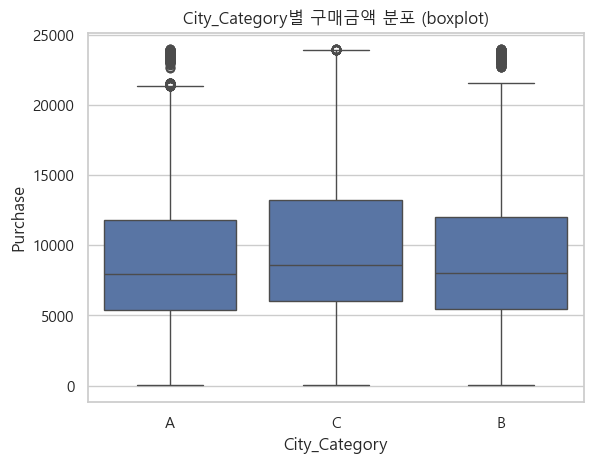

In [9]:
sns.boxplot(data=df, x="City_Category", y="Purchase")
plt.title("City_Category별 구매금액 분포 (boxplot)")
plt.xlabel("City_Category")
plt.ylabel("Purchase")
plt.show()

해석  
boxplot 기준으로 City C의 중앙값이 A/B보다 높게 나타난다.  
동시에 세 유형의 분포는 겹치는 구간이 넓어서, 차이가 있더라도 큰 격차라고 단정하기는 어렵다.

### 결과 1-2. 요약 통계

중앙값/평균/표준편차를 함께 확인한다. 중앙값이 높은 그룹과 분산이 큰 그룹은 다를 수 있다.

In [10]:
city_stats = df.groupby("City_Category")["Purchase"].agg(
    거래수="count",
    평균="mean",
    중앙값="median",
    표준편차="std"
).sort_index()
city_stats

,거래수,평균,중앙값,표준편차
City_Category,,,,
A,147720,8911.939216,7931.0,4892.115238
B,231173,9151.300563,8005.0,4955.496566
C,171175,9719.920993,8585.0,5189.465121


해석  
City C는 중앙값 기준 구매금액 수준이 상대적으로 높게 나타난다.  
다만 표준편차와 상단 꼬리(고액 구간) 특성은 유형마다 다를 수 있으므로, 평균만으로 결론을 내리기보다는 분포 기반으로 해석한다.

### 결과 1-3. 분포 모양(밀도) 확인

violinplot으로 값이 어디에 몰려 있는지(밀도)까지 확인한다.

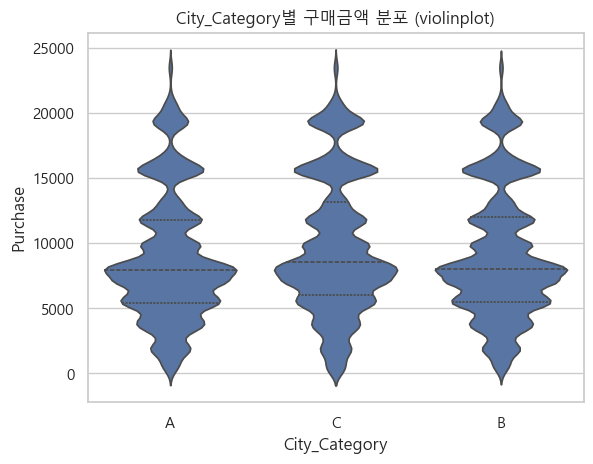

In [11]:
sns.violinplot(data=df, x="City_Category", y="Purchase", inner="quartile")
plt.title("City_Category별 구매금액 분포 (violinplot)")
plt.xlabel("City_Category")
plt.ylabel("Purchase")
plt.show()

해석  
City C는 분포 중심이 비교적 위쪽에 형성되는 경향이 보인다.  
다만 A/B/C 모두 밀도 곡선이 겹치는 구간이 넓어, 실질 차이 크기는 제한적일 가능성이 있다.

### 결과 1-4. 누적분포(ECDF)

ECDF는 특정 구매금액 임계값을 기준으로 각 그룹의 누적비율이 어떻게 달라지는지 보여준다.

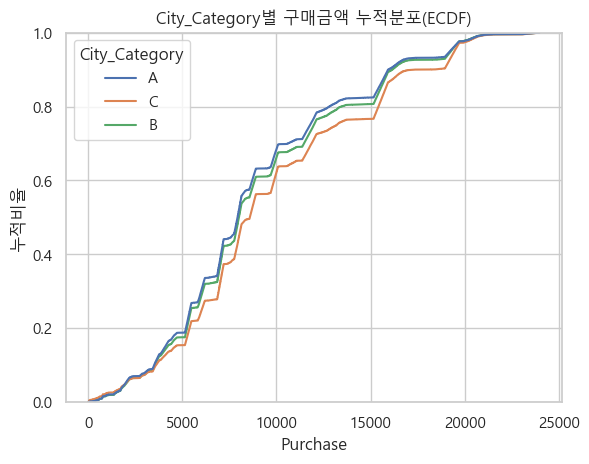

In [12]:
sns.ecdfplot(data=df, x="Purchase", hue="City_Category")
plt.title("City_Category별 구매금액 누적분포(ECDF)")
plt.xlabel("Purchase")
plt.ylabel("누적비율")
plt.show()

해석  
ECDF 곡선이 오른쪽에 위치할수록 같은 누적비율을 만들기 위해 더 큰 구매금액이 필요하다는 의미다.  
City C 곡선이 일부 구간에서 더 오른쪽으로 형성되면, 해당 구간에서 City C의 구매금액이 상대적으로 높은 패턴을 시사한다.

### 결과 1-5. 통계 검정(Kruskal-Wallis)

분포 차이를 비모수 검정으로 확인하고, 효과크기까지 함께 본다.

In [21]:
groups = [g["Purchase"].values for _, g in df.groupby("City_Category")]
kw1 = stats.kruskal(*groups)

n1 = len(df)
k1 = df["City_Category"].nunique()
eps2_1 = epsilon_squared_kw(kw1.statistic, n1, k1)

pd.DataFrame({
    "검정": ["Kruskal-Wallis"],
    "통계량(H)": [kw1.statistic],
    "p-value": [kw1.pvalue],
    "효과크기(epsilon^2)": [eps2_1]
})

,검정,통계량(H),p-value,효과크기(epsilon^2)
0,Kruskal-Wallis,2303.712732,0.0,0.004184


해석  
Kruskal-Wallis 결과 p-value가 매우 작게 나오면, City_Category 간 분포가 완전히 같다고 보긴 어렵다.  
다만 효과크기(epsilon²)가 매우 작게 나오면, 차이가 존재하더라도 실질 차이는 제한적일 가능성이 높다.  
따라서 결론은 유형 간 소비 구조 차이가 존재할 수 있다는 수준으로 정리한다.

### 결과 1-6. 사후 비교(쌍 비교)

어떤 쌍에서 차이가 나타나는지 Mann-Whitney U로 확인하고 Bonferroni 보정으로 보수적으로 판단한다.

In [22]:
cats = sorted(df["City_Category"].dropna().unique())
pairs = []
m = len(cats) * (len(cats) - 1) // 2

for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        c1, c2 = cats[i], cats[j]
        x = df.loc[df["City_Category"] == c1, "Purchase"]
        y = df.loc[df["City_Category"] == c2, "Purchase"]
        u = stats.mannwhitneyu(x, y, alternative="two-sided")
        pairs.append({
            "비교": f"{c1} vs {c2}",
            "U": u.statistic,
            "p_raw": u.pvalue,
            "p_bonf": bonferroni(u.pvalue, m)
        })

pairwise_city = pd.DataFrame(pairs).sort_values("p_bonf")
pairwise_city

,비교,U,p_raw,p_bonf
1,A vs C,1.145864e+10,0.000000e+00,0.000000e+00
2,B vs C,1.847086e+10,3.007485e-285,9.022456e-285
0,A vs B,1.660508e+10,2.396485e-46,7.189456e-46


가설 1 결론  
City_Category에 따라 구매금액 분포 차이는 통계적으로 확인된다.  
다만 효과크기가 작고 분포가 겹치는 구간이 넓어, 실무적으로 큰 격차로 단정하기보다는 유형 간 패턴 차이가 존재한다는 결론이 적절하다.

# 가설 2

## 질문
거주 기간(Stay_In_Current_City_Years)에 따라 구매금액(Purchase) 특성은 달라지는가?

## 가설
- H0: 거주 기간 그룹 간 Purchase 분포는 동일하다.
- H1: 거주 기간 그룹 간 Purchase 분포는 동일하지 않다.

## 분석 방법
- 분포 확인: boxplot + 표본 stripplot
- 분포 차이 검정: Kruskal-Wallis
- 단조 경향: Spearman 상관
- 분산 차이: Levene(중앙값 기준)

### 결과 2-1. 분포 시각화(요약)

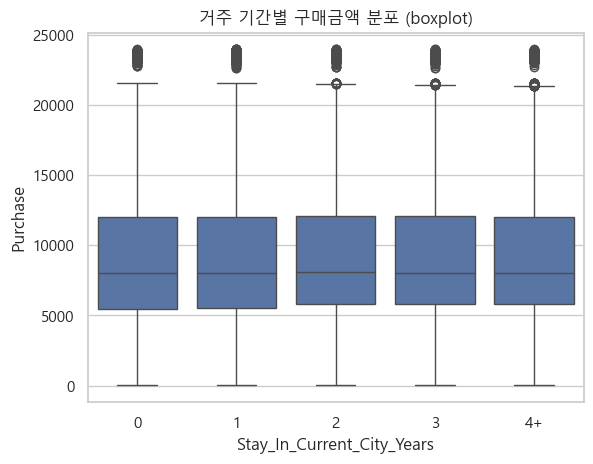

In [23]:
sns.boxplot(data=df, x="Stay_In_Current_City_Years", y="Purchase")
plt.title("거주 기간별 구매금액 분포 (boxplot)")
plt.xlabel("Stay_In_Current_City_Years")
plt.ylabel("Purchase")
plt.show()

해석  
거주 기간별 중앙값은 큰 폭으로 갈라지기보다는 비슷한 수준에서 소폭 변화하는 모습으로 나타나는 경우가 많다.  
따라서 이 변수는 구매금액 수준을 크게 가르는 변수라기보다, 약한 차이를 만드는 요인일 수 있다.

### 결과 2-2. 요약 통계

In [24]:
stay_stats = df.groupby("Stay_In_Current_City_Years")["Purchase"].agg(
    거래수="count",
    평균="mean",
    중앙값="median",
    표준편차="std"
)
stay_stats

,거래수,평균,중앙값,표준편차
Stay_In_Current_City_Years,,,,
0,74398,9180.075123,8025.0,4990.479940
1,193821,9250.145923,8041.0,5027.476933
2,101838,9320.429810,8072.0,5044.588224
3,95285,9286.904119,8047.0,5020.343541
4+,84726,9275.598872,8052.0,5017.627594


해석  
중앙값과 평균의 차이가 일관된 방향으로 커지지 않는다면, 거주 기간이 길수록 더 쓴다는 결론은 피하는 편이 맞다.  
대신 표준편차를 함께 보고 변동성이 달라지는지 확인한다.

### 결과 2-3. 표본 시각화(stripplot)

데이터가 매우 크므로, 표본을 추출해 점 분포로 변동성을 직관적으로 확인한다.

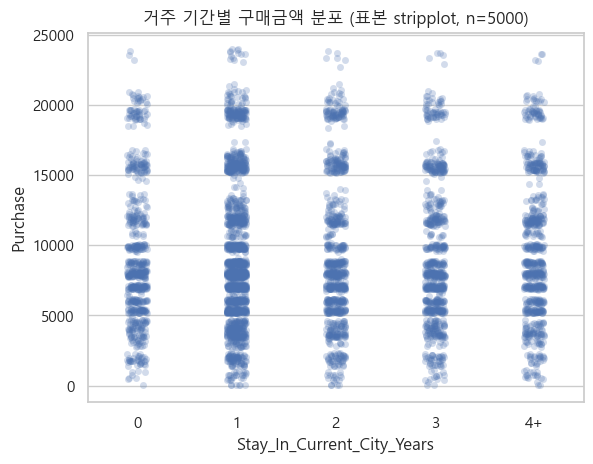

In [25]:
sample_df = df.sample(5000, random_state=42)
sns.stripplot(data=sample_df, x="Stay_In_Current_City_Years", y="Purchase", jitter=True, alpha=0.25)
plt.title("거주 기간별 구매금액 분포 (표본 stripplot, n=5000)")
plt.xlabel("Stay_In_Current_City_Years")
plt.ylabel("Purchase")
plt.show()

해석  
점들이 그룹별로 비슷하게 퍼져 있으면, 거주 기간만으로 구매금액이 크게 달라진다고 보기 어렵다.  
이 그림은 수준 차이보다 변동성 차이를 확인하는 보조 근거로 사용한다.

### 결과 2-4. 통계 검정(Kruskal-Wallis)

In [26]:
stay_groups = [g["Purchase"].values for _, g in df.groupby("Stay_In_Current_City_Years")]
kw2 = stats.kruskal(*stay_groups)

n2 = len(df)
k2 = df["Stay_In_Current_City_Years"].nunique()
eps2_2 = epsilon_squared_kw(kw2.statistic, n2, k2)

pd.DataFrame({
    "검정": ["Kruskal-Wallis"],
    "통계량(H)": [kw2.statistic],
    "p-value": [kw2.pvalue],
    "효과크기(epsilon^2)": [eps2_2]
})

,검정,통계량(H),p-value,효과크기(epsilon^2)
0,Kruskal-Wallis,34.097451,7.116707e-07,0.000055


해석  
p-value가 매우 작게 나올 수 있으나(표본이 크기 때문), 효과크기가 매우 작다면 실질 차이는 제한적이다.  
따라서 결론은 분포 차이가 완전히 없다고 말하기는 어렵지만, 거주 기간이 구매금액을 강하게 설명한다고 보기도 어렵다.

### 결과 2-5. 단조 경향(Spearman)

In [27]:
stay_map = {"0":0, "1":1, "2":2, "3":3, "4+":4}
stay_numeric = df["Stay_In_Current_City_Years"].astype(str).map(stay_map)

rho, p = stats.spearmanr(stay_numeric, df["Purchase"])
pd.DataFrame({
    "검정": ["Spearman rank correlation"],
    "rho": [rho],
    "p-value": [p]
})

,검정,rho,p-value
0,Spearman rank correlation,0.005944,0.00001


해석  
상관계수(rho)가 0에 매우 가까우면, 거주 기간이 길어질수록 구매금액이 증가한다는 단조 경향은 약하다고 해석한다.

### 결과 2-6. 분산 차이(Levene)

In [28]:
lev = stats.levene(*stay_groups, center="median")
pd.DataFrame({
    "검정": ["Levene (median center)"],
    "통계량": [lev.statistic],
    "p-value": [lev.pvalue]
})

,검정,통계량,p-value
0,Levene (median center),6.371329,0.00004


해석  
Levene이 유의하면 그룹 간 분산이 완전히 같다고 보기 어렵다.  
다만 이것이 곧 '분산 차이가 크다'는 의미는 아니므로, 표준편차와 그래프를 함께 보고 보수적으로 정리한다.

가설 2 결론  
거주 기간별 구매금액 분포는 통계적으로 차이가 있을 수 있으나, 효과크기와 경향 분석을 함께 보면 설명력은 제한적이다.  
따라서 거주 기간은 단독 변수로 타겟팅 기준을 삼기보다는, 다른 요인과 결합해서 보조적으로 해석하는 편이 적절하다.

# 가설 3

## 질문
제품 카테고리(Product_Category)별로 고객 특성(Gender, Age)이 편중되어 있는가?

## 가설(독립성 검정)
- 3-A: Product_Category와 Gender는 독립인가?
- 3-B: Product_Category와 Age는 독립인가?

## 분석 방법
- 교차표(crosstab)로 분포 확인
- Chi-square로 독립성 검정
- 효과크기(Cramer's V)로 차이 강도 확인
- 비율 시각화로 어떤 방향으로 차이가 나는지 확인

### 결과 3-A. Product_Category와 Gender

In [29]:
ct_gender = pd.crosstab(df["Product_Category"], df["Gender"])
ct_gender.head()

Gender,F,M
Product_Category,,
1,24831,115547
2,5658,18206
3,6006,14207
4,3639,8114
5,41961,108972


In [30]:
chi2_g, p_g, dof_g, exp_g = stats.chi2_contingency(ct_gender)
v_g = cramers_v(ct_gender)

pd.DataFrame({
    "검정": ["Chi-square (Product_Category x Gender)"],
    "chi2": [chi2_g],
    "dof": [dof_g],
    "p-value": [p_g],
    "효과크기(Cramer's V)": [v_g]
})

,검정,chi2,dof,p-value,효과크기(Cramer's V)
0,Chi-square (Product_Category x Gender),8070.411022,19,0.0,0.121127


비율 시각화(카테고리별 성별 구성)

비율로 보면 카테고리별 편중이 더 명확해진다.

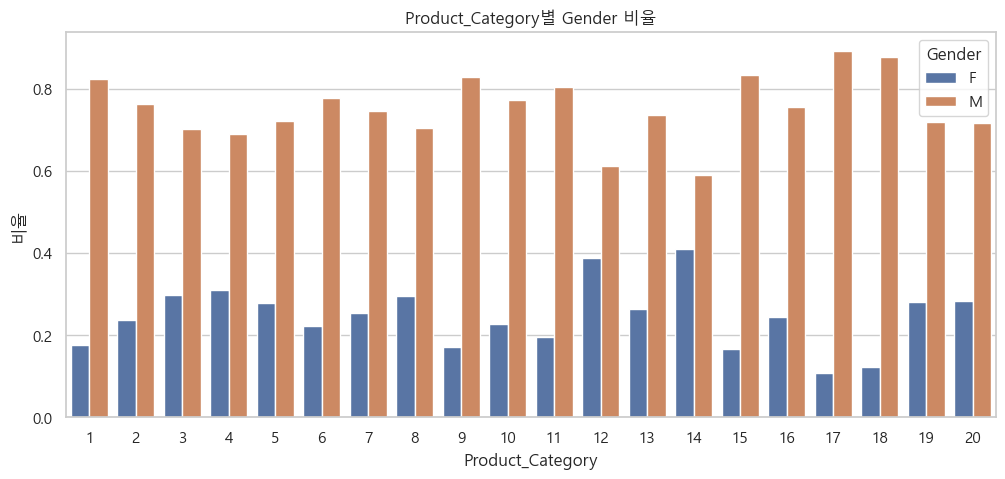

In [31]:
gender_ratio = ct_gender.div(ct_gender.sum(axis=1), axis=0).reset_index()
gender_ratio_melt = gender_ratio.melt(id_vars="Product_Category", var_name="Gender", value_name="비율")

plt.figure(figsize=(12, 5))
sns.barplot(data=gender_ratio_melt, x="Product_Category", y="비율", hue="Gender")
plt.title("Product_Category별 Gender 비율")
plt.xlabel("Product_Category")
plt.ylabel("비율")
plt.legend(title="Gender")
plt.show()

해석  
Chi-square가 유의하면, 성별 분포가 카테고리에 따라 동일하지 않다고 해석할 수 있다.  
다만 효과크기(Cramer's V)가 크지 않다면, 강한 분리라기보다는 약한 편중이 존재하는 수준으로 정리한다.

### 결과 3-B. Product_Category와 Age

In [32]:
ct_age = pd.crosstab(df["Product_Category"], df["Age"])
ct_age.iloc[:5, :5]

Age,0-17,18-25,26-35,36-45,46-50
Product_Category,,,,,
1,3585,26962,58249,27648,10474
2,805,4428,8928,4912,2105
3,1200,4710,7662,3854,1376
4,758,2463,4192,2354,990
5,4330,28522,61473,29377,11971


In [33]:
chi2_a, p_a, dof_a, exp_a = stats.chi2_contingency(ct_age)
v_a = cramers_v(ct_age)

pd.DataFrame({
    "검정": ["Chi-square (Product_Category x Age)"],
    "chi2": [chi2_a],
    "dof": [dof_a],
    "p-value": [p_a],
    "효과크기(Cramer's V)": [v_a]
})

,검정,chi2,dof,p-value,효과크기(Cramer's V)
0,Chi-square (Product_Category x Age),7637.28655,114,0.0,0.048105


비율 시각화(카테고리별 연령 구성)

카테고리 수가 많아 범례가 과해질 수 있어, 전체 흐름만 보도록 범례를 생략한다.

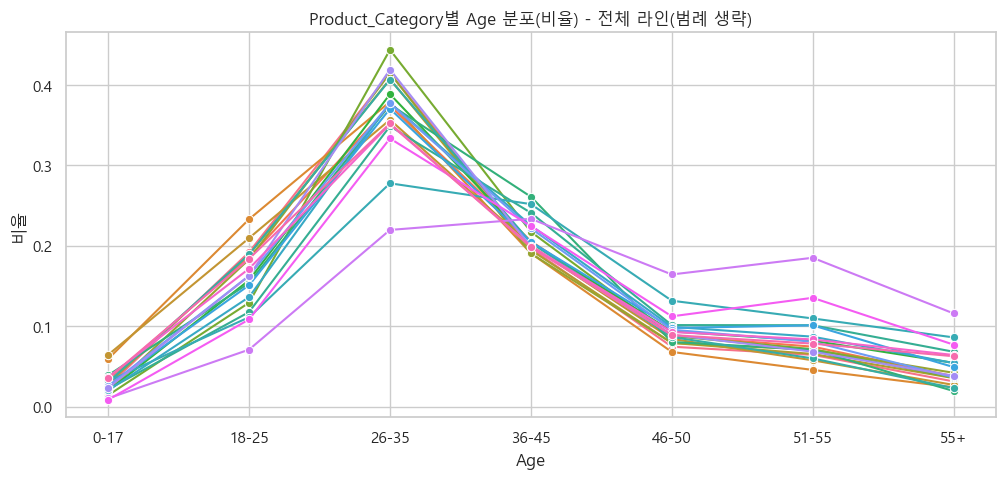

In [34]:
age_ratio = ct_age.div(ct_age.sum(axis=1), axis=0).reset_index()
age_ratio_melt = age_ratio.melt(id_vars="Product_Category", var_name="Age", value_name="비율")

plt.figure(figsize=(12, 5))
sns.lineplot(data=age_ratio_melt, x="Age", y="비율", hue="Product_Category", marker="o", legend=False)
plt.title("Product_Category별 Age 분포(비율) - 전체 라인(범례 생략)")
plt.xlabel("Age")
plt.ylabel("비율")
plt.show()

해석  
연령 분포 역시 Chi-square가 유의할 수 있으나, 효과크기가 작다면 차이 강도는 제한적이다.  
따라서 연령대별로 카테고리를 강하게 쪼개기보다는, 카테고리 운영 단위에서 메시지 톤이나 채널을 미세 조정하는 근거로 쓰는 것이 적절하다.

가설 3 결론  
제품 카테고리별로 성별/연령 구성의 차이는 통계적으로 확인될 수 있다.  
다만 효과크기를 고려하면, 결과는 강한 편중이라기보다 약한 편중이 존재한다는 수준으로 정리하는 것이 안정적이다.

# 보강 분석(결합 구조)

단일 변수 비교는 정보가 제한적일 수 있다.  
City_Category와 Product_Category를 결합해 평균 구매금액의 상대적 차이가 어디에서 나타나는지 한 장으로 정리한다.

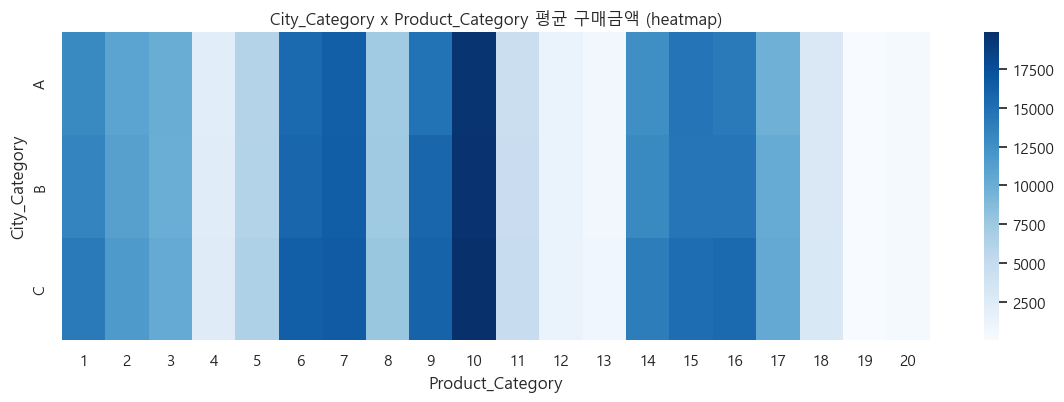

In [35]:
pivot_mean = df.pivot_table(values="Purchase", index="City_Category", columns="Product_Category", aggfunc="mean")
plt.figure(figsize=(14, 4))
sns.heatmap(pivot_mean, cmap="Blues")
plt.title("City_Category x Product_Category 평균 구매금액 (heatmap)")
plt.xlabel("Product_Category")
plt.ylabel("City_Category")
plt.show()

해석  
히트맵은 조합별 평균이 높아지는 구간을 빠르게 찾게 해준다.  
특정 조합에서 상대적으로 높은 값이 보이면, 단일 변수 분석에서 놓친 패턴이 존재했을 가능성이 있다.  
따라서 후속 분석은 교차 세그먼트 기반으로 진행하는 것이 자연스럽다.

# 관계성 분석(변수 간 연결고리 보기)

가설 검정은 “차이가 있는가?”를 봤다면, 관계성 분석은 “무엇과 무엇이 함께 움직이는가?”를 봅니다.

- **수치-수치**: 상관(Pearson/Spearman)
- **범주-범주**: 카이제곱 + **Cramér's V**(0~1)
- **범주-수치(Purchase)**: **Correlation Ratio(η, eta)**(0~1)

> 마스킹된 범주형 변수는 ‘라벨 의미’를 해석하기보다, **유형 간 패턴 존재 여부**만 확인합니다.


### (추가) 한방에 보는 그룹화 TOP3

관계성 지표(η, Cramér’s V 등)로 들어가기 전에, **그룹별 평균 Purchase TOP3**를 먼저 보면 “어떤 집단이 더 많이 쓰는지”가 한눈에 들어옵니다.  
- `count`(표본 수)도 같이 봐서 **너무 작은 집단의 착시**를 피합니다.


### 1) 그룹화 TOP3: ‘한방에 이해’용 스캐너

관계성 지표(η, Cramér’s V)를 보기 전에, 먼저 **범주형 변수별 평균 Purchase 상위 3개 레벨**을 뽑아 “누가 많이 쓰는지”를 직관적으로 확인합니다.

이 표는 *결론*이라기보다 **탐색용 신호(signal)**입니다.

체크 포인트:
- `count`(표본 수)가 너무 작으면 평균이 튈 수 있습니다.  
  따라서 **mean과 함께 count를 같이 보는 것**이 핵심입니다.
- 상위 그룹이 반복적으로 등장하는 변수는 이후 η 분석에서도 상위에 나올 가능성이 높습니다.


In [36]:
# 그룹화해서 Purchase(제품금액)에 '많이' 영향을 주는(=평균이 높은) 값 TOP3 보기
target = "Purchase"

# 보통 Walmart 구매 데이터에서 많이 쓰는 범주형들(존재하는 것만 자동 선택)
candidate_cats = [
    "Gender", "Age", "City_Category", "Stay_In_Current_City_Years",
    "Marital_Status", "Occupation", "Product_Category_1", "Product_Category_2", "Product_Category_3"
]
cat_cols = [c for c in candidate_cats if c in df.columns]

top3_tables = {}
for c in cat_cols:
    tmp = (
        df.groupby(c)[target]
          .agg(count="count", mean="mean", median="median")
          .sort_values("mean", ascending=False)
          .head(3)
          .reset_index()
    )
    top3_tables[c] = tmp

# 출력
for c, t in top3_tables.items():
    print(f"\n### {c} : 평균 Purchase TOP3")
    display(t)



### Gender : 평균 Purchase TOP3


,Gender,count,mean,median
0,M,414259,9437.526040,8098.0
1,F,135809,8734.565765,7914.0



### Age : 평균 Purchase TOP3


,Age,count,mean,median
0,51-55,38501,9534.808031,8130.0
1,55+,21504,9336.280459,8105.5
2,36-45,110013,9331.350695,8061.0



### City_Category : 평균 Purchase TOP3


,City_Category,count,mean,median
0,C,171175,9719.920993,8585.0
1,B,231173,9151.300563,8005.0
2,A,147720,8911.939216,7931.0



### Stay_In_Current_City_Years : 평균 Purchase TOP3


,Stay_In_Current_City_Years,count,mean,median
0,2,101838,9320.429810,8072.0
1,3,95285,9286.904119,8047.0
2,4+,84726,9275.598872,8052.0



### Marital_Status : 평균 Purchase TOP3


,Marital_Status,count,mean,median
0,0,324731,9265.907619,8044.0
1,1,225337,9261.174574,8051.0



### Occupation : 평균 Purchase TOP3


,Occupation,count,mean,median
0,17,40043,9821.478236,8635.0
1,12,31179,9796.640239,8569.0
2,15,12165,9778.891163,8513.0


### TOP3 표 결과 해석 가이드 (보고서용)

위 TOP3 표는 **"누가 평균적으로 더 많이 지출했는가"**를 한눈에 보여주는 스캐너입니다.

- **mean(평균 Purchase)**: 집단별 평균 구매금액. TOP3는 ‘높은 지출 집단’ 후보를 빠르게 찾는 용도입니다.  
- **median(중앙값)**: 평균이 이상치에 끌려 올라갔는지(혹은 전반적으로 높은지) 확인하는 안전장치입니다.  
- **count(표본수)**: 표본이 너무 작으면 평균이 흔들릴 수 있어, **해석 우선순위를 낮추거나** 추가 확인이 필요합니다.

아래 자동 요약 출력은 TOP1 그룹이 **전체 평균 대비 얼마나 높은지(+%)**와 **표본수 주의 여부**를 같이 보여줍니다.


In [37]:
# (해석) TOP3 결과값을 '보고서 문장'으로 자동 요약

overall_mean = df["Purchase"].mean()

def _size_flag(n):
    if n < 1000:
        return "⚠️ 표본 매우 작음(해석 주의)"
    if n < 5000:
        return "⚠️ 표본 작음(해석 주의)"
    return "표본 충분"

print(f"전체 평균 Purchase = {overall_mean:,.0f}")

for var, tbl in top3_tables.items():
    top = tbl.iloc[0]
    grp = top[var]
    n = int(top["count"])
    m = float(top["mean"])
    med = float(top.get("median", float("nan")))
    lift = (m / overall_mean - 1) * 100 if overall_mean else float("nan")
    
    print(f"\n[{var}]")
    print(f" - 평균 Purchase 상위 그룹: {grp} (mean={m:,.0f}, median={med:,.0f})")
    print(f" - 전체 평균 대비 +{lift:.1f}% / 표본수 {n:,} → {_size_flag(n)}")
    print(" - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.")


전체 평균 Purchase = 9,264

[Gender]
 - 평균 Purchase 상위 그룹: M (mean=9,438, median=8,098)
 - 전체 평균 대비 +1.9% / 표본수 414,259 → 표본 충분
 - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.

[Age]
 - 평균 Purchase 상위 그룹: 51-55 (mean=9,535, median=8,130)
 - 전체 평균 대비 +2.9% / 표본수 38,501 → 표본 충분
 - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.

[City_Category]
 - 평균 Purchase 상위 그룹: C (mean=9,720, median=8,585)
 - 전체 평균 대비 +4.9% / 표본수 171,175 → 표본 충분
 - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.

[Stay_In_Current_City_Years]
 - 평균 Purchase 상위 그룹: 2 (mean=9,320, median=8,072)
 - 전체 평균 대비 +0.6% / 표본수 101,838 → 표본 충분
 - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.

[Marital_Status]
 - 평균 Purchase 상위 그룹: 0.0 (mean=9,266, median=8,044)
 - 전체 평균 대비 +0.0% / 표본수 324,731 → 표본 충분
 - 해석: 해당 집단은 평균적으로 더 높은 지출을 보이며, 이후 교차분석으로 '왜 높은지'를 확인하는 게 자연스럽다.

[Occupation]
 - 평균 Purchase 상위 그룹: 17.0 (mean=9,821, median=8,635)
 - 전체 평균 대비 +6.0% / 표본수 40,043 →

In [38]:
# 1) 컬럼 타입 자동 분류
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df가 앞에서 이미 만들어졌다는 전제
assert "df" in globals(), "df 데이터프레임이 먼저 필요합니다."

# 범주형 후보(존재하는 것만)
cat_candidates = [
    "Gender", "Age", "Occupation", "City_Category",
    "Stay_In_Current_City_Years", "Marital_Status",
    "Product_Category_1", "Product_Category_2", "Product_Category_3",
    "Product_Category"  # 혹시 단일 카테고리 컬럼을 쓴 경우 대비
]
cat_cols = [c for c in cat_candidates if c in df.columns]

# 범주형으로 강제(이미 되어 있어도 OK)
for c in cat_cols:
    df[c] = df[c].astype("category")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "Purchase" in df.columns and "Purchase" not in num_cols:
    num_cols.append("Purchase")

cat_cols, num_cols


(['Gender',
  'Age',
  'Occupation',
  'City_Category',
  'Stay_In_Current_City_Years',
  'Marital_Status',
  'Product_Category'],
 ['User_ID', 'Purchase'])

### 2) 수치-수치 관계: 상관(Pearson/Spearman)

수치형 변수들끼리 “**같이 움직이는 정도**”를 상관으로 확인합니다.  
Purchase와의 상관은 “수치형 변수 증가/감소에 따라 구매금액이 같이 움직이는지”를 빠르게 보여줍니다.

- **Pearson**: 선형 관계에 민감합니다.
- **Spearman**: 순위 기반(비선형/왜도에 비교적 강함). 분포가 비정규일 때 보조 지표로 유용합니다.

보고서 문장 예시:
- “Purchase와 상관이 상대적으로 높은 수치형 변수는 **X**로 확인되었다(pearson/spearman 기준).”
- “상관은 인과가 아니므로, 이후에는 세그먼트별 비교 또는 추가 통제 변수를 고려해 해석한다.”


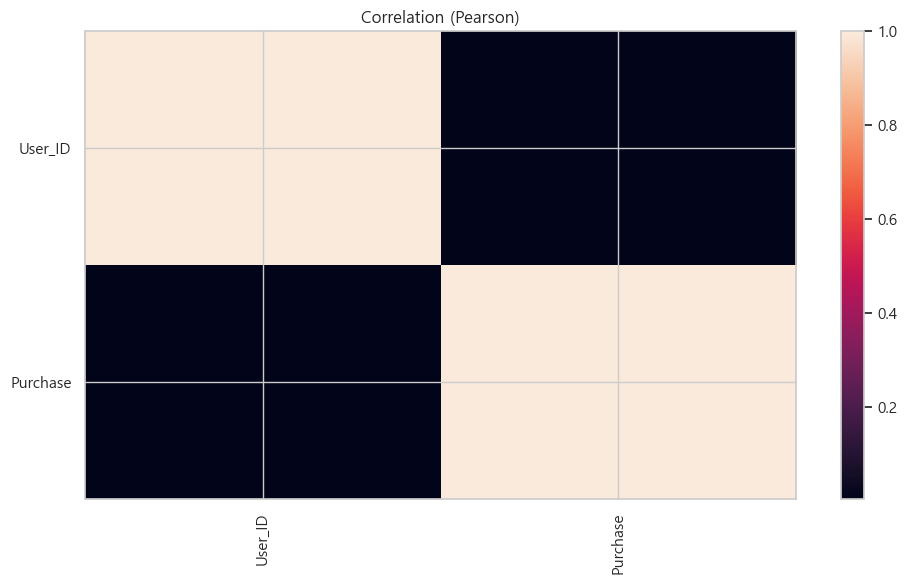

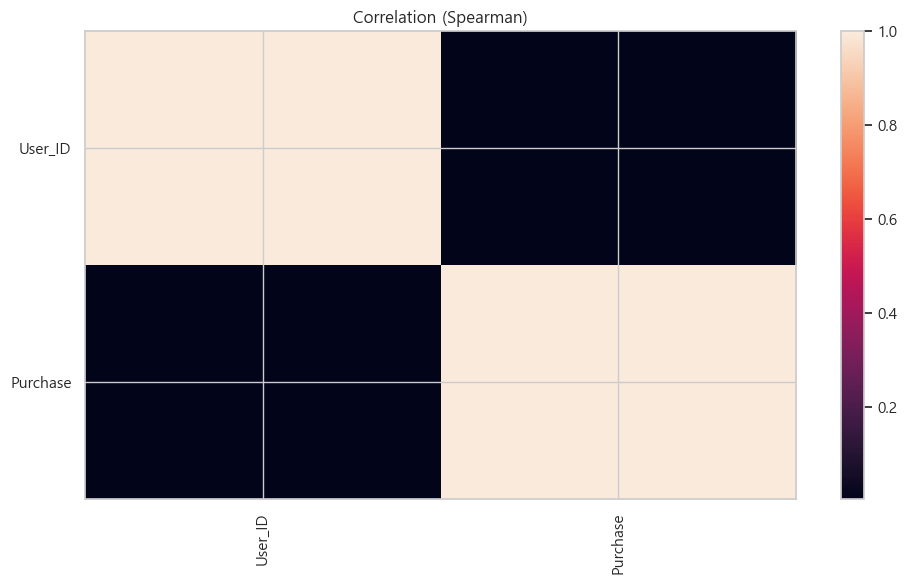

In [39]:
# 2) 수치-수치 관계: 상관(pearson/spearman)
# 상관은 인과가 아니라 "동행" 정도로 해석

num_cols2 = [c for c in num_cols if c in df.columns]
corr_p = df[num_cols2].corr(method="pearson")
corr_s = df[num_cols2].corr(method="spearman")

def show_corr(corr, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(corr.values, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

show_corr(corr_p, "Correlation (Pearson)")
show_corr(corr_s, "Correlation (Spearman)")


### 3) 범주-범주 관계: 카이제곱과 Cramér’s V

여기는 “**변수끼리 서로 얽혀 있는지(중복 설명 가능성)**”를 보는 구간입니다.  
예를 들어 `Age`와 `Product_Category`가 강하게 연결되어 있으면, Purchase에 대한 영향이 “나이 때문인지, 제품군 때문인지” 해석이 겹칠 수 있습니다.

- **카이제곱(Chi-square) p-value**: 두 범주형 변수가 독립인지 여부를 테스트합니다.
- **Cramér’s V**: 관계 강도(0~1). 값이 커질수록 두 변수의 연관이 강합니다.

해석 팁:
- p-value가 작고 Cramér’s V도 크면, “통계적으로도 유의하고 강도도 있는 연결”로 볼 수 있습니다.
- Cramér’s V가 높은 변수쌍은 이후 분석에서 **둘 중 하나만 대표로 쓰거나**, **교차 분리(층화)**해서 보는 게 안전합니다.


In [40]:
# 3) 범주-범주 관계: 카이제곱 + Cramér's V
from scipy import stats

def cramers_v(ct: pd.DataFrame) -> float:
    chi2 = stats.chi2_contingency(ct, correction=False)[0]
    n = ct.to_numpy().sum()
    r, k = ct.shape
    if n == 0:
        return np.nan
    return np.sqrt((chi2 / n) / (min(r - 1, k - 1) + 1e-12))

pairs = []
for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        a, b = cat_cols[i], cat_cols[j]
        ct = pd.crosstab(df[a], df[b])
        if ct.size == 0:
            continue
        p = stats.chi2_contingency(ct)[1]
        v = cramers_v(ct)
        pairs.append((a, b, v, p))

rel_cat_cat = pd.DataFrame(pairs, columns=["var1", "var2", "cramers_v", "p_value"])\
    .sort_values("cramers_v", ascending=False)

rel_cat_cat.head(15)


,var1,var2,cramers_v,p_value
6,Age,Occupation,0.424040,0.000000e+00
9,Age,Marital_Status,0.343856,0.000000e+00
1,Gender,Occupation,0.275217,0.000000e+00
13,Occupation,Marital_Status,0.184429,0.000000e+00
7,Age,City_Category,0.142593,0.000000e+00
11,Occupation,City_Category,0.132561,0.000000e+00
5,Gender,Product_Category,0.121127,0.000000e+00
12,Occupation,Stay_In_Current_City_Years,0.078041,0.000000e+00
0,Gender,Age,0.050678,4.275057e-302
8,Age,Stay_In_Current_City_Years,0.049884,0.000000e+00


### 범주형 변수 vs 범주형 변수 (Cramér's V) 해석

Cramér's V는 **두 범주형 변수가 얼마나 함께 움직이는지(연관 강도)**를 0~1로 보여줍니다.  
값이 크면 두 변수가 서로 얽혀 있을 가능성이 커서, 한 변수가 “영향”처럼 보일 때 사실은 다른 변수의 분포가 섞여 보일 수도 있습니다.

- V가 크다: 두 변수가 강하게 연결 → **중복 설명/교란 가능성** 체크 필요  
- V가 작다: 비교적 독립적 → 변수를 따로 해석해도 큰 무리 없음


In [41]:
# (해석) Cramér's V 결과값 상위 TOP5 요약

tmp = rel_cat_cat.copy().sort_values("cramers_v", ascending=False)

def v_band(v):
    if v >= 0.30:
        return "연관 강함(해석 시 얽힘 주의)"
    if v >= 0.15:
        return "연관 중간(교차분석 추천)"
    if v >= 0.07:
        return "연관 약함"
    return "연관 매우 약함"

print("Cramér's V 상위 5쌍(변수 얽힘 체크):")
for _, r in tmp.head(5).iterrows():
    v1, v2 = r["var1"], r["var2"]
    v = float(r["cramers_v"])
    p = float(r["p_value"])
    print(f" - {v1} × {v2}: V={v:.3f} → {v_band(v)} / p={p:.3g}")

print("\n해석: V가 높은 쌍은 '변수끼리 분포가 엮여' 있어, Purchase 차이를 해석할 때 교차표/히트맵으로 분리해 보는 것이 안전하다.")


Cramér's V 상위 5쌍(변수 얽힘 체크):
 - Age × Occupation: V=0.424 → 연관 강함(해석 시 얽힘 주의) / p=0
 - Age × Marital_Status: V=0.344 → 연관 강함(해석 시 얽힘 주의) / p=0
 - Gender × Occupation: V=0.275 → 연관 중간(교차분석 추천) / p=0
 - Occupation × Marital_Status: V=0.184 → 연관 중간(교차분석 추천) / p=0
 - Age × City_Category: V=0.143 → 연관 약함 / p=0

해석: V가 높은 쌍은 '변수끼리 분포가 엮여' 있어, Purchase 차이를 해석할 때 교차표/히트맵으로 분리해 보는 것이 안전하다.


### 4) 범주-수치(Purchase) 관계: η(eta)와 Kruskal-Wallis

이 단계는 “**어떤 범주형 변수가 Purchase(구매금액)의 차이를 가장 잘 설명하는가?**”를 정리합니다.

- **η(eta, Correlation Ratio)**: 0~1 사이 값.  
  0에 가까우면 “그 범주로 나눠도 Purchase가 거의 안 달라짐”, 1에 가까우면 “그 범주에 따라 Purchase가 크게 갈림”을 뜻합니다.
- **Kruskal-Wallis p-value**: 분포 가정을 덜 하는(비모수) 유의성 검정.  
  p-value가 충분히 작으면 “범주별로 Purchase가 동일하다고 보기 어렵다”는 신호입니다.

보고서에서는 보통 아래처럼 씁니다:
- “η 기준 상위 변수는 **A, B, C**였고, 이는 Purchase에 대한 **우선 분석 축**으로 적절하다.”
- “다만 표본 수가 작은 레벨이 섞이면 평균이 튈 수 있어, 이후 교차분석에서 **count 기준 필터링**을 함께 고려한다.”


In [42]:
# 4) 범주-수치(Purchase) 관계: Correlation Ratio(η) + Kruskal-Wallis
from scipy import stats

def correlation_ratio(categories, measurements) -> float:
    categories = pd.Series(categories).astype("category")
    measurements = pd.Series(measurements).astype(float)

    mask = categories.notna() & measurements.notna()
    categories = categories[mask]
    measurements = measurements[mask]

    if len(measurements) == 0:
        return np.nan

    y_mean = measurements.mean()
    ss_between = 0.0
    for lvl in categories.cat.categories:
        y_i = measurements[categories == lvl]
        if len(y_i) == 0:
            continue
        ss_between += len(y_i) * (y_i.mean() - y_mean) ** 2
    ss_total = ((measurements - y_mean) ** 2).sum()
    if ss_total == 0:
        return 0.0
    return np.sqrt(ss_between / ss_total)

assert "Purchase" in df.columns, "Purchase 컬럼이 필요합니다."

rows = []
for c in cat_cols:
    eta = correlation_ratio(df[c], df["Purchase"])
    groups = [df.loc[df[c] == lvl, "Purchase"].dropna().values for lvl in df[c].cat.categories]
    groups = [g for g in groups if len(g) > 0]
    kw_p = stats.kruskal(*groups).pvalue if len(groups) >= 2 else np.nan
    rows.append((c, eta, kw_p))

rel_cat_purchase = pd.DataFrame(rows, columns=["category", "eta(0~1)", "kruskal_p_value"])\
    .sort_values("eta(0~1)", ascending=False)

rel_cat_purchase


,category,eta(0~1),kruskal_p_value
6,Product_Category,0.797843,0.000000e+00
3,City_Category,0.063988,0.000000e+00
0,Gender,0.060346,0.000000e+00
2,Occupation,0.059731,0.000000e+00
1,Age,0.021033,3.612252e-65
4,Stay_In_Current_City_Years,0.008260,7.116707e-07
5,Marital_Status,0.000463,4.083234e-01


### 범주형 변수 vs Purchase (η, Correlation Ratio) 결과값 읽는 법

아래 표의 `eta(0~1)`는 **그 변수로 집단을 나눴을 때 Purchase 평균이 얼마나 ‘갈라지는지’**를 보여줍니다.  
즉, η가 높을수록 “이 변수 기준으로 세그먼트를 나누면 구매금액 차이가 더 선명하게 보인다”는 뜻입니다.

- **η가 높은 변수**: 이후 교차분석/타깃팅의 출발점으로 적합  
- **p-value(Kruskal)**: 통계적으로 ‘차이가 있다’는 근거(표본이 크면 아주 작은 차이도 유의해질 수 있으니 η와 같이 봄)

> 실무적 감(거친 가이드): η가 0.30 이상이면 꽤 뚜렷, 0.15 전후면 중간, 0.07 미만이면 약한 편으로 해석할 수 있습니다.


In [43]:
# (해석) η 결과값을 TOP3 중심으로 자동 요약 (보고서 문장용)

tmp = rel_cat_purchase.copy()
eta_col = [c for c in tmp.columns if "eta" in c.lower()][0]  # 'eta(0~1)' 같은 이름 대응
tmp = tmp.sort_values(eta_col, ascending=False)

def eta_band(x):
    if x >= 0.30:
        return "높음(집단 차이가 비교적 뚜렷)"
    if x >= 0.15:
        return "중간(차이는 있으나 보강 필요)"
    if x >= 0.07:
        return "낮음(약한 차이)"
    return "매우 낮음(거의 구분 안 됨)"

print("η 상위 3개(변수 우선순위 후보):")
for _, r in tmp.head(3).iterrows():
    c = r["category"]
    eta = float(r[eta_col])
    p = float(r["kruskal_p_value"]) if "kruskal_p_value" in tmp.columns else float("nan")
    print(f" - {c}: η={eta:.3f} → {eta_band(eta)} / Kruskal p={p:.3g}")

print("\n보고서 문장 예시:")
print(" - η 기준 상위 변수는 Purchase를 구분하는 축으로, 교차분석(예: City×Product) 및 세그먼트 타깃팅의 우선순위로 적절하다.")


η 상위 3개(변수 우선순위 후보):
 - Product_Category: η=0.798 → 높음(집단 차이가 비교적 뚜렷) / Kruskal p=0
 - City_Category: η=0.064 → 매우 낮음(거의 구분 안 됨) / Kruskal p=0
 - Gender: η=0.060 → 매우 낮음(거의 구분 안 됨) / Kruskal p=0

보고서 문장 예시:
 - η 기준 상위 변수는 Purchase를 구분하는 축으로, 교차분석(예: City×Product) 및 세그먼트 타깃팅의 우선순위로 적절하다.


### 변수 단위 요약(보고서용): “이 변수가 Purchase에 어떻게 연결되는가?”

아래 출력은 각 변수(예: City, Age, Occupation 등)에 대해:

- **TOP 지출 그룹(평균/중앙값/표본수)**이 무엇인지  
- **최저 지출 그룹과의 격차(%)**가 어느 정도인지  
- 해당 변수가 Purchase를 얼마나 “가르는지”를 나타내는 **η(eta) 값**  
을 한 문단으로 자동 요약합니다.

> 읽는 팁: TOP 그룹이 눈에 띄더라도 표본수가 너무 작으면 평균이 튈 수 있으니 `count`를 함께 보세요.


In [44]:
# (자동 요약) 변수 단위 Purchase 연결 설명 생성
# - top3_tables: 각 범주형 변수별 top3 테이블(dict)
# - rel_cat_purchase: 변수별 eta 테이블
# 필요 라이브러리: pandas, numpy (이미 앞에서 import 되어있다고 가정)

overall_mean = df["Purchase"].mean()

# eta 컬럼명은 버전에 따라 'eta(0~1)' 또는 'eta_correlation_ratio'일 수 있어 유연하게 처리
eta_col = None
for c in rel_cat_purchase.columns:
    if "eta" in c.lower():
        eta_col = c
        break

eta_map = {r["category"]: float(r[eta_col]) for _, r in rel_cat_purchase.iterrows()} if eta_col else {}

def eta_band(x):
    if x >= 0.30:
        return "높음(집단 차이가 비교적 뚜렷)"
    if x >= 0.15:
        return "중간(차이는 있으나 보강 필요)"
    if x >= 0.07:
        return "낮음(약한 차이)"
    return "매우 낮음(거의 구분 안 됨)"

def size_flag(n):
    if n < 1000:
        return "⚠️ 표본 매우 작음"
    if n < 5000:
        return "⚠️ 표본 작음"
    return "표본 충분"

print(f"전체 평균 Purchase = {overall_mean:,.0f}\n")

for var, tbl in top3_tables.items():
    # 변수별 전체 그룹 평균/최저/최고 계산
    grp_stats = df.groupby(var)["Purchase"].agg(["count", "mean", "median"]).dropna()
    if grp_stats.empty:
        continue
    
    top = grp_stats.sort_values("mean", ascending=False).iloc[0]
    bot = grp_stats.sort_values("mean", ascending=True).iloc[0]
    
    top_grp = grp_stats.sort_values("mean", ascending=False).index[0]
    bot_grp = grp_stats.sort_values("mean", ascending=True).index[0]
    
    top_mean = float(top["mean"])
    top_med  = float(top["median"])
    top_n    = int(top["count"])
    
    bot_mean = float(bot["mean"])
    bot_med  = float(bot["median"])
    bot_n    = int(bot["count"])
    
    gap_pct = ((top_mean / bot_mean) - 1) * 100 if bot_mean else float("nan")
    lift_pct = ((top_mean / overall_mean) - 1) * 100 if overall_mean else float("nan")
    
    eta = eta_map.get(var, float("nan"))
    eta_txt = f"η={eta:.3f} ({eta_band(eta)})" if eta == eta else "η=N/A"
    
    print(f"[{var}]")
    print(f" - 상위 지출 그룹: {top_grp} (mean={top_mean:,.0f}, median={top_med:,.0f}, n={top_n:,} → {size_flag(top_n)})")
    print(f" - 하위 지출 그룹: {bot_grp} (mean={bot_mean:,.0f}, median={bot_med:,.0f}, n={bot_n:,} → {size_flag(bot_n)})")
    print(f" - 격차: 상위/하위 평균 기준 +{gap_pct:.1f}%, 상위 그룹은 전체 평균 대비 +{lift_pct:.1f}%")
    print(f" - 변수 구분력(η): {eta_txt}")
    print(f" - 해석: '{var}'로 세그먼트를 나누면 구매금액의 차이가 위와 같이 관측되며, η 값은 이 변수의 구분력(관계 강도)을 뒷받침한다.")
    print("")


전체 평균 Purchase = 9,264

[Gender]
 - 상위 지출 그룹: M (mean=9,438, median=8,098, n=414,259 → 표본 충분)
 - 하위 지출 그룹: F (mean=8,735, median=7,914, n=135,809 → 표본 충분)
 - 격차: 상위/하위 평균 기준 +8.0%, 상위 그룹은 전체 평균 대비 +1.9%
 - 변수 구분력(η): η=0.060 (매우 낮음(거의 구분 안 됨))
 - 해석: 'Gender'로 세그먼트를 나누면 구매금액의 차이가 위와 같이 관측되며, η 값은 이 변수의 구분력(관계 강도)을 뒷받침한다.

[Age]
 - 상위 지출 그룹: 51-55 (mean=9,535, median=8,130, n=38,501 → 표본 충분)
 - 하위 지출 그룹: 0-17 (mean=8,933, median=7,986, n=15,102 → 표본 충분)
 - 격차: 상위/하위 평균 기준 +6.7%, 상위 그룹은 전체 평균 대비 +2.9%
 - 변수 구분력(η): η=0.021 (매우 낮음(거의 구분 안 됨))
 - 해석: 'Age'로 세그먼트를 나누면 구매금액의 차이가 위와 같이 관측되며, η 값은 이 변수의 구분력(관계 강도)을 뒷받침한다.

[City_Category]
 - 상위 지출 그룹: C (mean=9,720, median=8,585, n=171,175 → 표본 충분)
 - 하위 지출 그룹: A (mean=8,912, median=7,931, n=147,720 → 표본 충분)
 - 격차: 상위/하위 평균 기준 +9.1%, 상위 그룹은 전체 평균 대비 +4.9%
 - 변수 구분력(η): η=0.064 (매우 낮음(거의 구분 안 됨))
 - 해석: 'City_Category'로 세그먼트를 나누면 구매금액의 차이가 위와 같이 관측되며, η 값은 이 변수의 구분력(관계 강도)을 뒷받침한다.

[Stay_In_Current_City_Years]
 - 상위 지출 그룹: 2 (mean=9,320, median

# 종합 결론 및 시사점

본 분석을 종합하면 다음과 같이 정리된다.

1) City_Category에 따른 구매금액 분포 차이는 통계적으로 확인된다.  
다만 효과크기가 작고 분포 겹침이 넓어, 큰 격차보다는 유형 간 패턴 차이로 해석하는 것이 적절하다.

2) 거주 기간은 구매금액 수준을 강하게 설명하지 않는다.  
분포 차이는 관찰될 수 있으나, 효과크기와 경향 분석을 고려하면 설명력은 제한적이다.  
따라서 단독 타겟팅 변수보다는 보조 변수로 쓰는 편이 맞다.

3) 제품 카테고리별로 고객 구성 차이는 존재할 수 있다.  
독립성은 기각될 수 있으나, 효과크기가 크지 않다면 약한 편중 수준으로 정리하고 과도한 타겟 분리를 피하는 것이 안전하다.

실무 적용 관점에서는, 단일 변수 기반의 단순 세분화보다  
City_Category x Product_Category 같은 교차 세그먼트로 접근하는 방향이 더 설득력 있다.

## 한계

- 마스킹 변수의 실제 의미가 공개되지 않아, 관찰된 차이를 소득/지역경제 등 외부 요인으로 직접 연결하기 어렵다.
- 관측 데이터 기반 분석이며, 인과관계를 주장하지 않는다.
- 구매 시점, 프로모션 여부 등 맥락 변수가 없어 설명력에 구조적 한계가 있다.

## 후속 분석 제안

- 교차 세그먼트(City_Category x Product_Category)별 분포(중앙값/상단 꼬리) 비교
- 상위 구매금액 구간(예: 상위 10%)을 정의해 고액 구매 패턴을 별도로 분석
- 추가 변수가 확보된다면(프로모션, 시즌, 매장 정보), 동일 프레임으로 재검정